Following the original 11 equations from Wong & Wang, 2006. Although it will be more than 11 for more decision options.

$$
\begin{equation}
\begin{aligned}
\tau_r \frac{d r_i}{dt} &= -r_i + \phi(I_{syn, i}) \quad\text{ for } i = 0, \dots, p\\
\tau_r \frac{d r_I}{dt} &= -r_I + \phi(I_{syn, I})\\
\frac{d S_{AMPA,i}}{dt} &= -\frac{S_{AMPA,i}}{\tau_{AMPA}} + r_i \quad\text{ for } i = 0, \dots, p\\
\frac{d S_{NMDA,i}}{dt} &= -\frac{S_{NMDA,i}}{\tau_{NMDA}} + (1-S_{NMDA,i})F(\psi(r_i)) \quad\text{ for } i = 0, \dots, p\\
\frac{d S_{GABA}}{dt} &= -\frac{S_{GABA}}{\tau_{GABA}} + r_I
\end{aligned}
\end{equation}
$$

where $\tau_r = 2ms$, $\phi$ is given by the first-passage time formula i.e.

$$
\phi(I_{syn}) = \left(\tau_{refrac} + \tau_m \sqrt{\pi} \int_{\frac{V_{reset} - V_{SS}}{\sigma_V}}^{\frac{V_{thr} - V_{SS}}{\sigma_V}} e^{x^2}(1 + erf(x))dx\right)^{-1}
$$

with $V_{SS} = V_L + I_{syn}/g_m$ and $g_m$, $\tau_{refrac}$ and $\tau_m$ depended on the cell type.

and $I_{syn,x}$ is the input potential computed assuming a constant driving force (details yet to be determined, and noise to be added later) and $\psi$ is the steady-state fraction of open NMDA-mediated channels for the input firing rate, and

$$
F(\psi) = \psi / (\tau_{NMDA}(1-\psi))
$$

The remaining parameter originally were:

$$
\begin{equation}
\begin{aligned}
\sigma_v &= \text{???} \\
\tau_{NMDA} &= 0.5 ms^{-1} \times 2 ms \times 100 ms \\
\tau_{AMPA} &= 2 ms \\
\tau_{GABA} &= 10 ms\\
V_{reset} &= -55 mV\\
V_{thr} &= -50 mV\\
V_L &= -70 mV\\
\tau_{m,E} &= 0.5 nF / g_{m,E}\\
\tau_{m,I} &= 0.2 nF / g_{m,I}\\
\tau_{refrac, E} &= 2ms\\
\tau_{refrac, I} &= 1ms\\
g_{m,E} &= 25 nS\\
g_{m,I} &= 20 nS\\
\end{aligned}
\end{equation}
$$

as well as terms for the noise and determining $I_{syn}$ generally (conductances, synaptic stengths and driving forces; conductances may depend on number of neurons as in Brunel & Wang).

The noise for the input currents were given in Wong & Wang by

$$
\tau_{AMPA} \frac{d I_{noise,i}}{dt} = -I_{noise,i} + \eta \sqrt{\tau_{AMPA} \sigma^2_{noise}}
$$

where $\eta$ is a white-noise process and $\sigma_{noise} = 0.007nA$

In [1]:
import numba
from scipy import integrate

First get the spiking model "right" and then reduce it to a rate model.

In [2]:
import brian2 as b2
from brian2 import np


def run_simulation(use_current=True, V_avg=-47.5):

    N = 1000
    N_E = int(N * 0.8)  # pyramidal neurons
    N_I = int(N * 0.2)
    f = 0.1
    p = 5
    N_sub = int(N_E * f)
    N_non = N_E - p*N_sub
    w_plus = 2.1
    w_minus = 1.0 - f*(w_plus - 1.0) / (1.0 - f)
    C_ext = 800
    rate_ext = 3 * b2.Hz
    C_E = N_E
    C_I = N_I

    namespace = dict(
        V_L = -70. * b2.mV,
        V_thr = -50. * b2.mV,
        V_reset = -55. * b2.mV,
        V_E = 0. * b2.mV,
        V_I = -70. * b2.mV,
        V_avg = V_avg * b2.mV,

        C_m_E = 0.5 * b2.nF,
        C_m_I = 0.2 * b2.nF,

        g_m_E = 25. * b2.nS,
        g_m_I = 20. * b2.nS,

        tau_rp_E = 2. * b2.ms,
        tau_rp_I = 1. * b2.ms,

        g_AMPA_ext_E = 2.08 * b2.nS,
        g_AMPA_rec_E = 0.104 * b2.nS * 800. / N_E,
        g_AMPA_ext_I = 1.62 * b2.nS,
        g_AMPA_rec_I = 0.081 * b2.nS * 800. / N_E,
        tau_AMPA = 2. * b2.ms,

        g_NMDA_E = 0.327 * b2.nS * 800. / N_E,
        g_NMDA_I = 0.258 * b2.nS * 800. / N_E,
        tau_NMDA_rise = 2. * b2.ms,
        tau_NMDA_decay = 100. * b2.ms,
        alpha = 0.5 / b2.ms,
        Mg2 = 1.,

        g_GABA_E = 1.25 * b2.nS * 200. / N_I,
        g_GABA_I = 0.973 * b2.nS * 200. / N_I,
        tau_GABA = 10. * b2.ms,
    )

#     runtime = 4.0 * b2.second
    runtime = 0.4 * b2.second

    if not use_current:
        eqs_E = '''
        dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

        I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

        I_AMPA_ext = g_AMPA_ext_E * (v - V_E) * s_AMPA_ext : amp
        I_AMPA_rec = g_AMPA_rec_E * (v - V_E) * 1 * s_AMPA : amp
        ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
        ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

        I_NMDA_rec = g_NMDA_E * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
        s_NMDA_tot : 1

        I_GABA_rec = g_GABA_E * (v - V_I) * s_GABA : amp
        ds_GABA / dt = - s_GABA / tau_GABA : 1
        '''

        eqs_I = '''
        dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

        I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

        I_AMPA_ext = g_AMPA_ext_I * (v - V_E) * s_AMPA_ext : amp
        I_AMPA_rec = g_AMPA_rec_I * (v - V_E) * 1 * s_AMPA : amp
        ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
        ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

        I_NMDA_rec = g_NMDA_I * (v - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
        s_NMDA_tot : 1

        I_GABA_rec = g_GABA_I * (v - V_I) * s_GABA : amp
        ds_GABA / dt = - s_GABA / tau_GABA : 1
        '''
    else:
        eqs_E = '''
        dv / dt = (- g_m_E * (v - V_L) - I_syn) / C_m_E : volt (unless refractory)

        I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

        I_AMPA_ext = g_AMPA_ext_E * (V_avg - V_E) * s_AMPA_ext : amp
        I_AMPA_rec = g_AMPA_rec_E * (V_avg - V_E) * 1 * s_AMPA : amp
        ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
        ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

        I_NMDA_rec = g_NMDA_E * (V_avg - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
        s_NMDA_tot : 1

        I_GABA_rec = g_GABA_E * (V_avg + 2*mV - V_I) * s_GABA : amp
        ds_GABA / dt = - s_GABA / tau_GABA : 1
        '''

        eqs_I = '''
        dv / dt = (- g_m_I * (v - V_L) - I_syn) / C_m_I : volt (unless refractory)

        I_syn = I_AMPA_ext + I_AMPA_rec + I_NMDA_rec + I_GABA_rec : amp

        I_AMPA_ext = g_AMPA_ext_I * (V_avg - V_E) * s_AMPA_ext : amp
        I_AMPA_rec = g_AMPA_rec_I * (V_avg - V_E) * 1 * s_AMPA : amp
        ds_AMPA_ext / dt = - s_AMPA_ext / tau_AMPA : 1
        ds_AMPA / dt = - s_AMPA / tau_AMPA : 1

        I_NMDA_rec = g_NMDA_I * (V_avg - V_E) / (1 + Mg2 * exp(-0.062 * v / mV) / 3.57) * s_NMDA_tot : amp
        s_NMDA_tot : 1

        I_GABA_rec = g_GABA_I * (V_avg + 2*mV - V_I) * s_GABA : amp
        ds_GABA / dt = - s_GABA / tau_GABA : 1
        '''

    P_E = b2.NeuronGroup(
        N_E, eqs_E, threshold='v > V_thr',
        reset='v = V_reset', refractory='tau_rp_E', method='euler'
    )
    P_E.v = namespace['V_L']
    P_E.s_AMPA_ext = 4.8
    P_I = b2.NeuronGroup(
        N_I, eqs_I, threshold='v > V_thr',
        reset='v = V_reset', refractory='tau_rp_I', method='euler'
    )
    P_I.v = namespace['V_L']
    P_I.s_AMPA_ext = 4.8
    

    eqs_glut = '''
    s_NMDA_tot_post = w * s_NMDA : 1 (summed)
    ds_NMDA / dt = - s_NMDA / tau_NMDA_decay + alpha * x * (1 - s_NMDA) : 1 (clock-driven)
    dx / dt = - x / tau_NMDA_rise : 1 (clock-driven)
    w : 1
    '''
    eqs_pre_glut = '''
    s_AMPA += w
    x += 1
    '''
    eqs_pre_gaba = '''
    s_GABA += 1
    '''
    eqs_pre_ext = '''
    s_AMPA_ext += 1
    '''
    eqs_post_glut = ''

    C_E_E = b2.Synapses(P_E, P_E, 
        model=eqs_glut, on_pre=eqs_pre_glut, on_post=eqs_post_glut,
        method='euler', name='C_E_E')
    C_E_E.connect('i != j')
    C_E_E.w[:] = 1.0
    for pi in range(N_non, N_non + p * N_sub, N_sub):
        # internal other subpopulation to current nonselective
        C_E_E.w[C_E_E.indices[:, pi:pi + N_sub]] = w_minus
        # internal current subpopulation to current subpopulation
        C_E_E.w[C_E_E.indices[pi:pi + N_sub, pi:pi + N_sub]] = w_plus

    C_E_I = b2.Synapses(
        P_E, P_I, model=eqs_glut, on_pre=eqs_pre_glut, method='euler',
        name='C_E_I'
    )
    C_E_I.connect()
    C_E_I.w[:] = 1.0
    C_I_I = b2.Synapses(
        P_I, P_I, on_pre=eqs_pre_gaba, method='euler',
        name='C_I_I'
    )
    C_I_I.connect('i != j')
    # C_I_I.w[:] = 1.0
    C_I_E = b2.Synapses(P_I, P_E, on_pre=eqs_pre_gaba, method='euler')
    C_I_E.connect()
    # C_I_E.w[:] = 1.0

    C_P_E = b2.PoissonInput(
        P_E, 's_AMPA_ext', C_ext, rate_ext, '1',
#         name='C_P_E'
    )
    C_P_I = b2.PoissonInput(
        P_I, 's_AMPA_ext', C_ext, rate_ext, '1',
#         name='C_P_I'
    )


    C_selection = int(f * C_ext)
    stimtime = 1
    rate_selection = 25 * b2.Hz
#     stimuli1 = b2.TimedArray(np.r_[np.zeros(40), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
    stimuli1 = b2.TimedArray(np.r_[np.zeros(8), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
    input1 = b2.PoissonInput(
        P_E[N_non:N_non + N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli1(t)'
    )
    stimuli2 = b2.TimedArray(np.r_[np.zeros(80), np.ones(stimtime), np.zeros(100)], dt=25 * b2.ms)
    input2 = b2.PoissonInput(
        P_E[N_non + N_sub:N_non + 2 * N_sub], 's_AMPA_ext', C_selection, rate_selection, 'stimuli2(t)'
    )
    stimuli_reset = b2.TimedArray(np.r_[np.zeros(120), np.ones(2), np.zeros(100)], dt=25 * b2.ms)
    input_reset_I = b2.PoissonInput(P_E, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')
    input_reset_E = b2.PoissonInput(P_I, 's_AMPA_ext', C_ext, rate_selection, 'stimuli_reset(t)')

    namespace['stimuli1'] = stimuli1
    namespace['stimuli2'] = stimuli2
    namespace['stimuli_reset'] = stimuli_reset

    N_activity_plot = 15
    sp_E_sels = [
        b2.SpikeMonitor(P_E[pi:pi + N_activity_plot], name=f'sp_E_{int(pi/N_sub)}')
        for pi in range(N_non, N_non + p * N_sub, N_sub)
    ]
    sp_E = b2.SpikeMonitor(P_E[:N_activity_plot], name=f'sp_E_non')
    sp_I = b2.SpikeMonitor(P_I[:N_activity_plot], name=f'sp_I')

    r_E_sels = [
        b2.PopulationRateMonitor(P_E[pi:pi + N_sub], name=f'r_E_{int(pi/N_sub)}')
        for pi in range(N_non, N_non + p * N_sub, N_sub)]
    r_E = b2.PopulationRateMonitor(P_E[:N_non], name=f'r_E_non')
    r_I = b2.PopulationRateMonitor(P_I, name=f'r_I')

    st_E_sels = [
        b2.StateMonitor(P_E[pi:pi + N_activity_plot], variables=True, record=True,
                       name=f'st_E_{int(pi/N_sub)}')
        for pi in range(N_non, N_non + p * N_sub, N_sub)]
    st_E = b2.StateMonitor(P_E[:N_activity_plot], variables=True, record=True, name=f'st_E_non')
    st_I = b2.StateMonitor(P_I[:N_activity_plot], variables=True, record=True, name=f'st_I')

    # b2.run(runtime)
    net = b2.Network(b2.collect())
    net.add(sp_E_sels)
    net.add(r_E_sels)
    net.add(st_E_sels)

    net.run(runtime,
        report='stdout',
        namespace=namespace
    )

    b2.title('Population rates')
    b2.xlabel('ms')
    b2.ylabel('Hz')

    b2.plot(
        r_E.t / b2.ms, r_E.smooth_rate(width=25 * b2.ms) / b2.Hz,
        label='nonselective')
    b2.plot(
        r_I.t / b2.ms, r_I.smooth_rate(width=25 * b2.ms) / b2.Hz,
        label='inhibitory')

    for i, r_E_sel in enumerate(r_E_sels[::-1]):
        b2.plot(
            r_E_sel.t / b2.ms, r_E_sel.smooth_rate(width=25 * b2.ms) / b2.Hz,
            label='selective {}'.format(p - i))

    b2.legend()
    b2.figure()
    b2.title('Population activities ({} neurons/pop)'.format(N_activity_plot))
    b2.xlabel('ms')
    b2.yticks([])

    b2.plot(
        sp_E.t / b2.ms, sp_E.i + (p + 1) * N_activity_plot, '.',
        markersize=2, label='nonselective')
    b2.plot(
        sp_I.t / b2.ms, sp_I.i + p * N_activity_plot, '.',
        markersize=2, label='inhibitory')

    for i, sp_E_sel in enumerate(sp_E_sels[::-1]):
        b2.plot(
            sp_E_sel.t / b2.ms, sp_E_sel.i + (p - i - 1) * N_activity_plot, '.',
            markersize=2, label='selective {}'.format(p - i))

    b2.legend()
    b2.show()
    
    return net

Starting simulation at t=0. s for a duration of 0.4 s
274.9 ms (68%) simulated in 10s, estimated 5s remaining.
0.4 s (100%) simulated in 14s


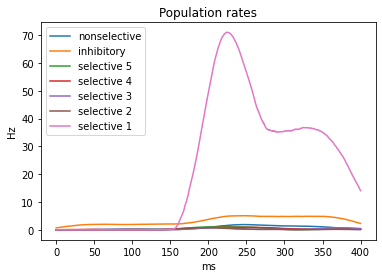

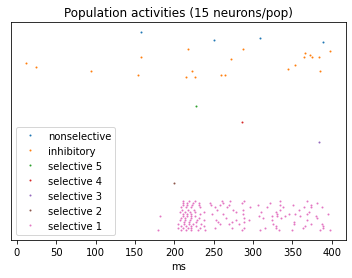

In [3]:
net = run_simulation(use_current=True)

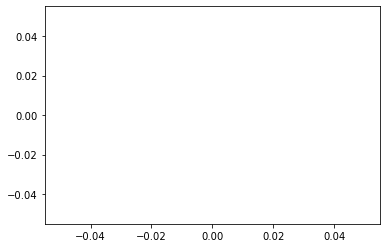

In [4]:
st_E_sel = net['st_E_5']
b2.plot(st_E_sel.s_AMPA_ext[0, 9000:11000] / 4.8)

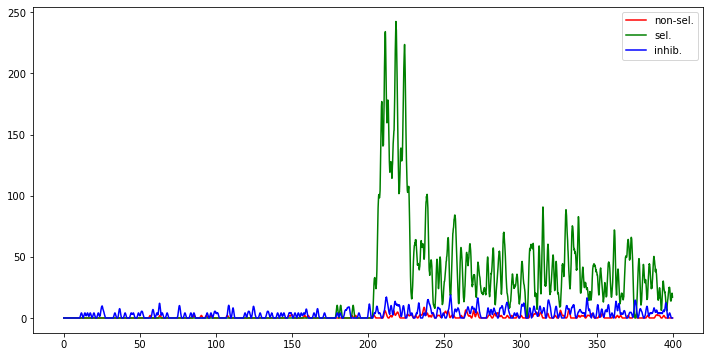

In [5]:
# n = 12000
# n0 = 8000

b2.figure(figsize=(12, 6))

nu_E = net['r_E_non']
b2.plot(
    nu_E.t / b2.ms,
    nu_E.smooth_rate('gaussian', 0.5*b2.ms),
    color='r', label='non-sel.')

nu_E_sel = net['r_E_5']
b2.plot(
    nu_E_sel.t / b2.ms,
    nu_E_sel.smooth_rate('gaussian', 0.5*b2.ms),
    color='g', label='sel.')

nu_I = net['r_I']
b2.plot(
    nu_I.t / b2.ms,
    nu_I.smooth_rate('gaussian', 0.5*b2.ms),
    color='b', label='inhib.')
b2.legend()
b2.show()

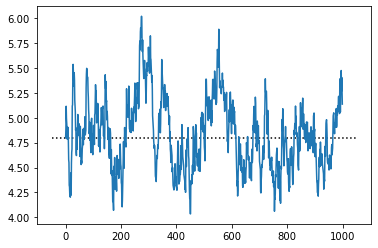

In [6]:
b2.plot(net['st_E_non'].s_AMPA_ext.mean(axis=0)[:1000])
xlim = b2.xlim()
b2.hlines(4.8, xlim[0], xlim[1], color='k', ls=':')

In [12]:
# b2.plot((net['st_E_non'].I_syn / b2.nA)[0])
# np.mean((net['st_E_non'].I_syn / b2.nA)[0])
np.mean(net['st_E_non'].I_AMPA_ext/b2.pA, axis=0)[0], \
np.mean(net['st_E_non'].I_AMPA_rec/b2.pA, axis=0)[0], \
np.mean(net['st_E_non'].I_NMDA_rec/b2.pA, axis=0)[0], \
np.mean(net['st_E_non'].I_GABA_rec/b2.pA, axis=0)[0]
# np.var(net['st_E_non'].I_AMPA_ext/b2.pA)

(-474.2399999999999, 0.0, 0.0, 0.0)

In [7]:
V_L = -70. * b2.mV
V_thr = -50. * b2.mV
V_reset = -55. * b2.mV
g_m = 25. * b2.nS
tau_m = 20. * b2.ms
tau_rp = 2. * b2.ms

V_SS = V_L - net['st_E_non'].I_syn.mean(axis=0) / g_m
nu = net['r_E_non'].smooth_rate('gaussian', 10*b2.ms)
V_avg = V_SS - (V_thr - V_reset) * nu * tau_m #- (V_SS - V_reset) * nu * tau_rp

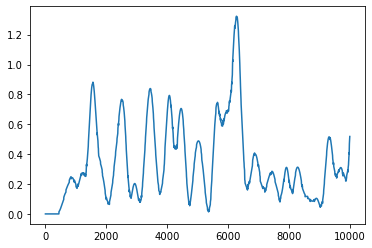

In [8]:
b2.plot(nu[:10000] / b2.Hz)

In [9]:
# V_SS[1000]
net['st_E_non'].I_syn.mean(axis=0)[1000] / b2.nA

-0.41218846290497846

In [193]:
v_std[1000] / b2.mV

1.2813976232341926

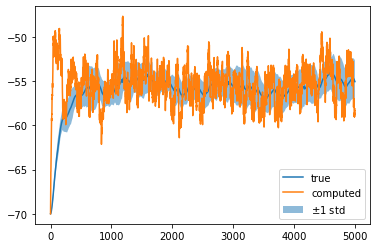

In [169]:
tstep_max = 5000

v_mean = b2.mean(net['st_E_non'].v, axis=0)
v_std = b2.std(net['st_E_non'].v, axis=0)
b2.plot(v_mean[:tstep_max] / b2.mV, label='true')
b2.fill_between(
    np.arange(tstep_max),
    (v_mean-v_std)[:tstep_max]/b2.mV,
    (v_mean+v_std)[:tstep_max]/b2.mV,
    alpha=0.5,
    label=r'$\pm 1$ std'
)
b2.plot(V_avg[:tstep_max] / b2.mV, label='computed')
b2.legend();

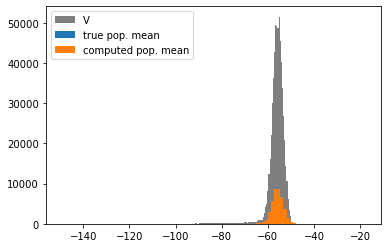

In [143]:
b2.hist(net['st_E_non'].v.ravel() / b2.mV, bins=100, label='V', color='k', alpha=0.5);
b2.hist(b2.mean(net['st_E_non'].v, axis=0) / b2.mV, bins=100, label='true pop. mean');
b2.hist(V_avg / b2.mV, bins=100, label='computed pop. mean');
b2.legend();

Starting simulation at t=0. s for a duration of 4. s
0.3274 s (8%) simulated in 10s, estimated 1m 52s remaining.
0.658 s (16%) simulated in 20s, estimated 1m 42s remaining.
0.9801 s (24%) simulated in 30s, estimated 1m 32s remaining.
1.3041 s (32%) simulated in 40s, estimated 1m 23s remaining.
1.6185 s (40%) simulated in 50s, estimated 1m 14s remaining.
1.8798 s (46%) simulated in 1m 0s, estimated 1m 8s remaining.
2.1144 s (52%) simulated in 1m 10s, estimated 1m 2s remaining.
2.3315 s (58%) simulated in 1m 20s, estimated 57s remaining.
2.525 s (63%) simulated in 1m 30s, estimated 53s remaining.
2.7146 s (67%) simulated in 1m 40s, estimated 47s remaining.
2.8968 s (72%) simulated in 1m 50s, estimated 42s remaining.
3.1 s (77%) simulated in 2m 0s, estimated 35s remaining.
3.3456 s (83%) simulated in 2m 10s, estimated 25s remaining.
3.5729 s (89%) simulated in 2m 20s, estimated 17s remaining.
3.7914 s (94%) simulated in 2m 30s, estimated 8s remaining.
4. s (100%) simulated in 2m 39s


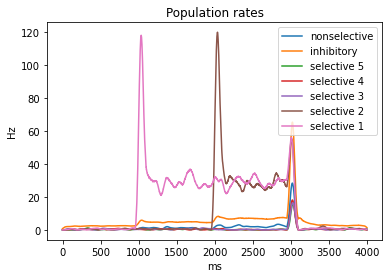

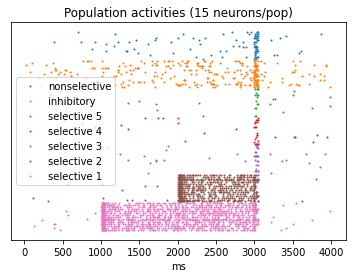

In [2]:
net = run_simulation(use_current=True, V_avg=-47.5)

Starting simulation at t=0. s for a duration of 4. s
0.3284 s (8%) simulated in 10s, estimated 1m 52s remaining.
0.6591 s (16%) simulated in 20s, estimated 1m 41s remaining.
0.9898 s (24%) simulated in 30s, estimated 1m 31s remaining.
1.3187 s (32%) simulated in 40s, estimated 1m 21s remaining.
1.6405 s (41%) simulated in 50s, estimated 1m 12s remaining.
1.9097 s (47%) simulated in 1m 0s, estimated 1m 6s remaining.
2.1657 s (54%) simulated in 1m 10s, estimated 59s remaining.
2.399 s (59%) simulated in 1m 20s, estimated 53s remaining.
2.5978 s (64%) simulated in 1m 30s, estimated 49s remaining.
2.7773 s (69%) simulated in 1m 40s, estimated 44s remaining.
2.9379 s (73%) simulated in 1m 50s, estimated 40s remaining.
3.1419 s (78%) simulated in 2m 0s, estimated 33s remaining.
3.3853 s (84%) simulated in 2m 10s, estimated 24s remaining.
3.6186 s (90%) simulated in 2m 20s, estimated 15s remaining.
3.8522 s (96%) simulated in 2m 30s, estimated 6s remaining.
4. s (100%) simulated in 2m 36s


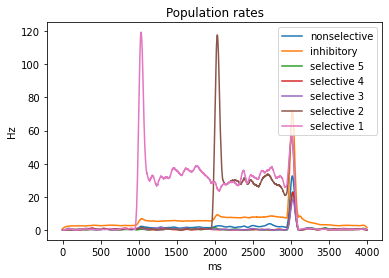

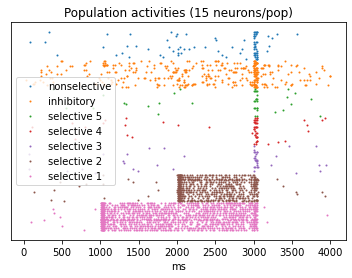

In [7]:
net = run_simulation(use_current=True, V_avg=-47.5)

---

### Current-Based (-50 mV):

mean:  -56.28701680237271 
variance:  19.15025538391787
mean (restricted):  -55.91218154956794 
variance (restricted):  7.717149096379953


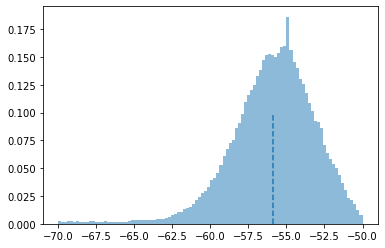

In [6]:
st = net['st_E_non']
# b2.plt.cm.rainbow(0.5)
v = st.v.reshape(-1) / b2.mV
b2.hist(v[v >= -70], bins=100, density=True, alpha=0.5)
b2.vlines(np.mean(v[v >= -70]), 0.0, 0.1, ls='--')
print("mean: ", np.mean(v), "\nvariance: ", np.var(v))
print("mean (restricted): ", np.mean(v[v >= -70]), "\nvariance (restricted): ", np.var(v[v >= -70]))
b2.show()

### Current-Based (-47.5 mV):

mean:  -56.165932391971225 
variance:  12.506421642325504
mean (restricted):  -55.94865651745611 
variance (restricted):  6.441376974553204


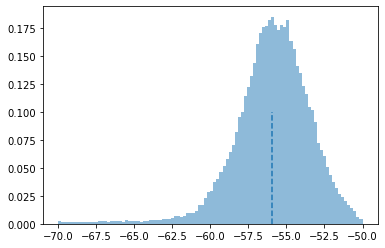

In [8]:
st = net['st_E_non']
# b2.plt.cm.rainbow(0.5)
v = st.v.reshape(-1) / b2.mV
b2.hist(v[v >= -70], bins=100, density=True, alpha=0.5)
b2.vlines(np.mean(v[v >= -70]), 0.0, 0.1, ls='--')
print("mean: ", np.mean(v), "\nvariance: ", np.var(v))
print("mean (restricted): ", np.mean(v[v >= -70]), "\nvariance (restricted): ", np.var(v[v >= -70]))
b2.show()

### Conductance-Based:

mean:  -53.323172486984134 
variance:  2.5200007662919703


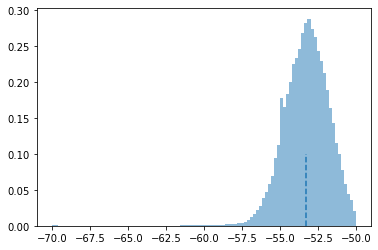

In [13]:
st = net['st_E_non']
# b2.plt.cm.rainbow(0.5)
b2.hist(st.v.reshape(-1) / b2.mV, bins=100, density=True, alpha=0.5)
b2.vlines(np.mean(st.v.reshape(-1) / b2.mV), 0.0, 0.1, ls='--')
print("mean: ", np.mean(st.v.reshape(-1) / b2.mV), "\nvariance: ", np.var(st.v.reshape(-1) / b2.mV))
b2.show()